## Steps to solve Emergency Vehicle Classification Problem using CNN in PyTorch

1. Loading the dataset
2. Preprocessing the data
3. Creating training and validation data
4. Defining the model architecture
5. Compiling the model (defining loss function, optimizer)
6. Training the model
7. Evaluating model performance
8. Save the best model and use it for prediction

### 1. Loading the dataset

In [1]:
# importing the required libraries

%matplotlib inline

import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# importing libraries for defining architecture of model
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import Linear, ReLU, BCELoss, Sequential, Sigmoid, Conv2d, MaxPool2d

#### Dataset:

you can access the Emergency Vehicles Identification dataset used in this notebook from the following link:

[Emergency Vehicles Identification dataset](https://www.kaggle.com/datasets/abhisheksinghblr/emergency-vehicles-identification)

In [3]:
# reading the csv file
data = pd.read_csv('Emergency_Vehicles/train.csv')

In [4]:
# looking at first five rows of the data
data.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [5]:
data.shape

(1646, 2)

In [6]:
# load images to store it in numpy array

# Empty list to store the images
X = []

# Iterating over each image
for img_name in data.image_names:
    # Loading image using its name
    img = plt.imread('Emergency_Vehicles/train/' + img_name)

    # Normalizing pixel values
    img = img / 255.0

    # Saving each image in the list
    X.append(img)

# Converting list of images into array
X = np.array(X)

In [7]:
# shape of input images
X.shape

(1646, 224, 224, 3)

In [8]:
# storing target in separate variable
y = data.emergency_or_not.values

# target variable shape
y.shape

(1646,)

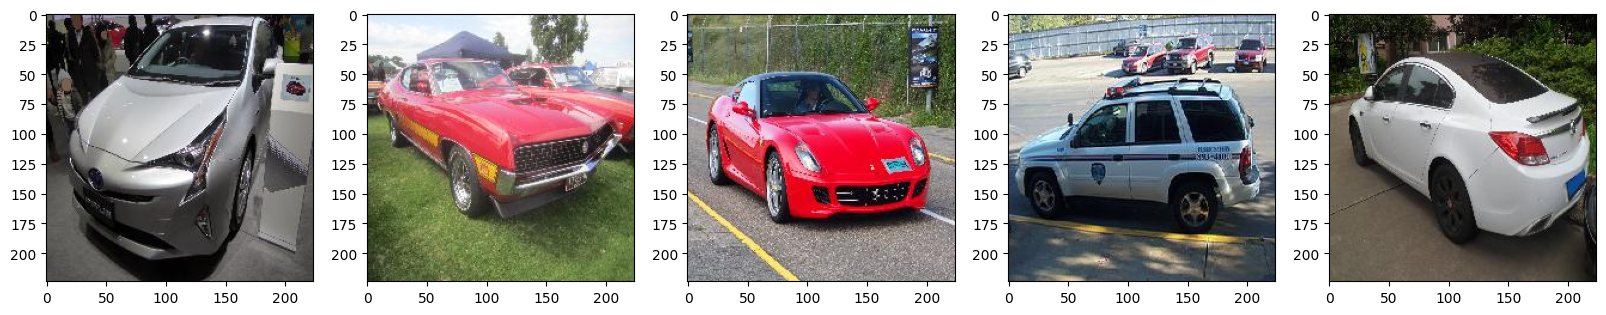

In [9]:
# plotting input images
fig, ax = plt.subplots(ncols=5, figsize=(20,10))
for i in range(5):
  ax[i].imshow(X[i])

### 2. Preprocessing the data

In [10]:
# reshaping array as pytorch accepts channels as the first dimension of an image
X = np.moveaxis(X, -1, 1)
X.shape

(1646, 3, 224, 224)

### 3. Creating training and validation data

In [11]:
# creating training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state = 48, stratify=y)

In [12]:
# shape of training and validation data
(X_train.shape, y_train.shape), (X_valid.shape, y_valid.shape)

(((1399, 3, 224, 224), (1399,)), ((247, 3, 224, 224), (247,)))

In [13]:
# converting train and validation set to PyTorch tensor

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

X_valid = torch.FloatTensor(X_valid)
y_valid = torch.FloatTensor(y_valid)

### 4. Defining the model architecture

In [14]:
# defining CNN architecture

# Input
# Conv2d(64, kernel_size=(3, 3), stride=(1, 1), 'relu')
# MaxPool2d((2, 2), stride = 2)
# Conv2d(128, kernel_size=(3, 3), stride=(1, 1), 'relu')
# MaxPool2d((2, 2), stride = 2)
# Linear(64, 'relu')
# Linear(1, 'sigmoid')

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    # define the convolution block
    self.conv_layers = Sequential(

        # (batch_size, 3, 224, 224)
        Conv2d(in_channels = 3, out_channels = 64, kernel_size=3),

        # (batch_size, 64, 222, 222)
        ReLU(),

        # (batch_size, 64, 222, 222)
        MaxPool2d(kernel_size = 2, stride = 2),

        # (batch_size, 64, 111, 111)
        Conv2d(64, 128, 3),

        # (batch_size, 128, 109, 109)
        ReLU(),

        # (batch_size, 128, 109, 109)
        MaxPool2d(kernel_size = 2, stride = 2),
    )

    # define the dense block
    self.linear_layers = Sequential(

        # (batch_size, 128, 54, 54)
        Linear(128 * 54 * 54, 64),

        # (batch_size, 128*54*54)
        ReLU(),

        # (batch_size, 64)
        Linear(64, 1),

        # (batch_size, 1)
        Sigmoid()
    )

  # defining the forward pass
  def forward(self, x):

    # convolution block
    x = self.conv_layers(x)

    # flattening the output
    x = x.reshape(x.size(0), -1)

    # dense block
    x = self.linear_layers(x)

    return x

### 5. Compiling the model (defining loss function, optimizer)

In [15]:
# for same default initialization
torch.manual_seed(33)

# defining the model
model = Net()

print(model)

Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=373248, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [16]:
# pass an image to understand wheteher defined architecture is valid or not
model(X_train[0].reshape(1, 3, 224, 224))

tensor([[0.4851]], grad_fn=<SigmoidBackward0>)

In [17]:
# define optimizer ad loss
optimizer = Adam(model.parameters(), lr = 0.001)
criterion = nn.BCELoss()

### 6. Training the model

In [18]:
# define metric
def binary_accuracy(predictions, y):

  # round predictions to the closest integer
  rounded_preds = torch.round(predictions)

  # number of correctly classified
  correct = (rounded_preds == y).float()

  # compute accuracy
  acc = correct.sum()/len(correct)

  return acc

In [19]:
# define the training function

def train(X, y, batch_size):

  # defining the training phase
  model.train()

  # initialization
  epoch_loss, epoch_acc = 0, 0
  no_of_batches = 0

  # randomly create indices
  indices = torch.randperm(len(X))

  # loading in batches
  for i in range(0, len(indices), batch_size):

      # indices for a batch
      ind = indices[i:i+batch_size]

      # getting images and labels for batch
      batch_x, batch_y = X[ind], y[ind]

      # clearing all accumulated gradients
      optimizer.zero_grad()

      # forward pass
      outputs = model(batch_x)

      # converting to 1 dimensional tensor
      outputs = outputs.squeeze()

      # calculating loss
      loss = criterion(outputs, batch_y)
      acc = binary_accuracy(outputs, batch_y)

      # backward pass
      loss.backward()

      # update the weights
      optimizer.step()

      # keep track of the loss and accuracy of epoch
      epoch_loss = epoch_loss + loss.item()
      epoch_acc = epoch_acc + acc.item()

      # number os batches
      no_of_batches = no_of_batches + 1

  return epoch_loss/no_of_batches, epoch_acc/no_of_batches

### 7. Evaluating model performance

In [20]:
# define the evaluation function
def evaluate(X, y, batch_size):

  # prediction phase
  model.eval()

  # initialization
  epoch_loss, epoch_acc = 0, 0
  no_of_batches = 0

  # randomly create indices
  indices = torch.randperm(len(X))

  # deactivates autograd
  with torch.no_grad():

    # loading in batches
    for i in range(0, len(indices), batch_size):

      # indices for a batch
      ind = indices[i:i+batch_size]

      # batch
      batch_x, batch_y = X[ind], y[ind]

      # forawrd pass
      outputs = model(batch_x)

      # convert the output to 1 dimensional tensor
      outputs = outputs.squeeze()

      # calculate loss and accuarcy
      loss = criterion(outputs, batch_y)
      acc = binary_accuracy(outputs, batch_y)

      # keep track of loss and accuracy of an epoch
      epoch_loss = epoch_loss + loss.item()
      epoch_acc = epoch_acc + acc.item()

      # number of batches
      no_of_batches = no_of_batches + 1

  return epoch_loss/no_of_batches, epoch_acc/no_of_batches

In [21]:
# define prediction function
def predict(X, batch_size):

  # deactivate training phase
  model.eval()

  # initialization
  predictions = []

  # create indices
  indices = torch.arange(len(X))

  # activates autograd
  with torch.no_grad():

    for i in range(0, len(X), batch_size):

      # indices for a batch
      ind = indices[i:i+batch_size]

      # batch
      batch_x = X[ind]

      # forawrd pass
      outputs = model(batch_x)

      # convert the output to 1 dimensional tensor
      outputs = outputs.squeeze()

      # convert to numpy array
      prediction = outputs.data.cpu().numpy()
      predictions.append(prediction)

  # convert to single numpy array
  predictions = np.concatenate(predictions, axis = 0)

  return predictions

### 8. Save the best model and use it for prediction

In [23]:
N_EPOCHS = 5
batch_size = 32

# initialization
best_valid_acc = 0

# Create lists to store training and validation losses
train_losses = []
valid_losses = []

# Create lists to store training and validation accuracies
train_accuracies = []
valid_accuracies = []

for epoch in range(N_EPOCHS):

  # train the model
  train_loss, train_acc = train(X_train, y_train, batch_size)

  # evaluate the model
  valid_loss, valid_acc = evaluate(X_valid, y_valid, batch_size)

  # Append losses and accuracies to lists
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  train_accuracies.append(train_acc)
  valid_accuracies.append(valid_acc)

  print('epoch : ', epoch,
        'training loss: ', round(train_loss, 4),
        'training accuracy: ', round(train_acc, 4),
        'validation loss: ', round(valid_loss, 4),
        'validation accuracy: ', round(valid_acc, 4),
        )

  # save the best model
  if best_valid_acc <= valid_acc:
    best_valid_acc = valid_acc
    torch.save(model.state_dict(), 'saved_weights.pt')
    print('------------------------------------------ saved best model ----------------------------------------------')

epoch :  0 training loss:  0.8646 training accuracy:  0.609 validation loss:  0.5959 validation accuracy:  0.7009
------------------------------------------ saved best model ----------------------------------------------
epoch :  1 training loss:  0.5348 training accuracy:  0.7486 validation loss:  0.5058 validation accuracy:  0.7339
------------------------------------------ saved best model ----------------------------------------------
epoch :  2 training loss:  0.4359 training accuracy:  0.7979 validation loss:  0.501 validation accuracy:  0.7775
------------------------------------------ saved best model ----------------------------------------------
epoch :  3 training loss:  0.3648 training accuracy:  0.8482 validation loss:  0.5002 validation accuracy:  0.7775
------------------------------------------ saved best model ----------------------------------------------
epoch :  4 training loss:  0.31 training accuracy:  0.8665 validation loss:  0.5084 validation accuracy:  0.7899
-

In [24]:
# load weights of the best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [25]:
# evaluate the model
train_loss, train_accuracy = evaluate(X_train, y_train, batch_size)
valid_loss, valid_accuracy = evaluate(X_valid, y_valid, batch_size)

print('Final Training Accuracy: ', (train_accuracy) * 100)
print('Final Validation Accuracy: ', (valid_accuracy) * 100)

Final Training Accuracy:  89.93021249771118
Final Validation Accuracy:  78.68546172976494


In [26]:
# get predictions
predictions = predict(X_valid, batch_size)

In [27]:
# print first five predictions
predictions[:5]

array([0.99410313, 0.29043004, 0.67214495, 0.35720983, 0.9888371 ],
      dtype=float32)